In [1]:
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import yfinance as yfin
import pandas_ta as ta
import datetime as dt

In [23]:
def GetData(symbols, start_date, end_date):
    all_data = {}
    yfin.pdr_override()
    for symbol in symbols:
        data = pdr.get_data_yahoo(symbol, start = start_date, end = end_date, interval = "1h")
        data = data.drop(["Adj Close", "Volume"], axis = 1)
        all_data[symbol] = data
    return all_data

symbols = ["GBPJPY=X", "GBPUSD=X", "GBPCHF=X", "GBPAUD=X", "GBPNZD=X"]

years = 1 / 12
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days = (365 * years))

data = GetData(symbols, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
data = pd.read_csv("GBPJPY_H4_202201030000_202401040000.csv")
all_rows = []
for i, row in data.iterrows():
    new_row = str(row.values[0]).split("\t")
    new_row = new_row[:-2]
    new_row = (new_row[0] + " " + new_row[1], new_row[2:])
    all_rows.append(new_row)
    
all_dates = [val[0] for val in all_rows]
all_OHLCV = [val[1] for val in all_rows]
data = pd.DataFrame(data = all_OHLCV, index = all_dates, columns = ["Open", "High", "Low", "Close", "Volume"])
data = data.astype(float)
data.index = pd.to_datetime(data.index)
data

,Open,High,Low,Close,Volume
2022-01-03 00:00:00,155.630,155.921,154.892,155.468,60065.0
2022-01-04 00:00:00,155.371,157.432,155.343,157.116,78547.0
2022-01-05 00:00:00,157.028,157.767,156.578,157.399,83543.0
2022-01-06 00:00:00,157.324,157.472,156.090,156.810,83612.0
2022-01-07 00:00:00,156.685,157.186,156.682,157.055,71086.0
...,...,...,...,...,...
2024-01-03 08:00:00,179.509,180.350,179.449,180.118,22874.0
2024-01-03 12:00:00,180.113,180.668,180.033,180.629,23258.0
2024-01-03 16:00:00,180.627,181.745,180.550,181.587,31538.0
2024-01-03 20:00:00,181.588,181.753,181.254,181.467,21994.0


In [7]:
data["EMA"] = ta.dema(data["Close"], length = 14)
data["SMA"] = ta.sma(data["Close"], length = 50)
data["ATR"] = ta.atr(data["High"], data["Low"], data["Close"])
data["bullishcrossover"] = 0.0
data["bullishcross"] = np.where(data["EMA"] > data["SMA"], 1.0, 0.0)
data["crossover"] = data["bullishcross"].diff()
data["bullishengulfing"] = 0.0
for i in range(len(data)):
    if data["Open"].iloc[i] < data["Open"].iloc[i-1] and data["Close"].iloc[i] > data["Close"].iloc[i-1]:
        data["bullishengulfing"].iloc[i] = 1.0
    elif data["Open"].iloc[i] > data["Open"].iloc[i-1] and data["Close"].iloc[i] < data["Close"].iloc[i-1]:
        data["bullishengulfing"].iloc[i] = -1.0
    else:
        data["bullishengulfing"].iloc[i] = 0.0
data["position"] = 0.0
for i in range(len(data)):
    if data["crossover"].iloc[i] == 1.0 and data["bullishengulfing"].iloc[i] == 1.0:
        data["position"].iloc[i] = 1.0
    elif data["crossover"].iloc[i] == -1.0 and data["bullishengulfing"].iloc[i] == -1.0:
        data["position"].iloc[i] = -1.0

In [24]:
for symbol in symbols:
    data[symbol]["EMA"] = ta.dema(data[symbol]["Close"], length = 14)
    data[symbol]["SMA"] = ta.sma(data[symbol]["Close"], length = 50)
    data[symbol]["ATR"] = ta.atr(data[symbol]["High"], data[symbol]["Low"], data[symbol]["Close"])
    data[symbol]["bullishcrossover"] = 0.0
    data[symbol]["bullishcross"] = np.where(data[symbol]["EMA"] > data[symbol]["SMA"], 1.0, 0.0)
    data[symbol]["crossover"] = data[symbol]["bullishcross"].diff()
    data[symbol]["bullishengulfing"] = 0.0
    for i in range(len(data[symbol])):
        if data[symbol]["Open"].iloc[i] < data[symbol]["Open"].iloc[i-1] and data[symbol]["Close"].iloc[i] > data[symbol]["Close"].iloc[i-1]:
            data[symbol]["bullishengulfing"].iloc[i] = 1.0
        elif data[symbol]["Open"].iloc[i] > data[symbol]["Open"].iloc[i-1] and data[symbol]["Close"].iloc[i] < data[symbol]["Close"].iloc[i-1]:
            data[symbol]["bullishengulfing"].iloc[i] = -1.0
        else:
            data[symbol]["bullishengulfing"].iloc[i] = 0.0
    data[symbol]["position"] = 0.0
    for i in range(len(data[symbol])):
        if data[symbol]["crossover"].iloc[i] == 1.0 and data[symbol]["bullishengulfing"].iloc[i] == 1.0:
            data[symbol]["position"].iloc[i] = 1.0
        elif data[symbol]["crossover"].iloc[i] == -1.0 and data[symbol]["bullishengulfing"].iloc[i] == -1.0:
            data[symbol]["position"].iloc[i] = -1.0
    

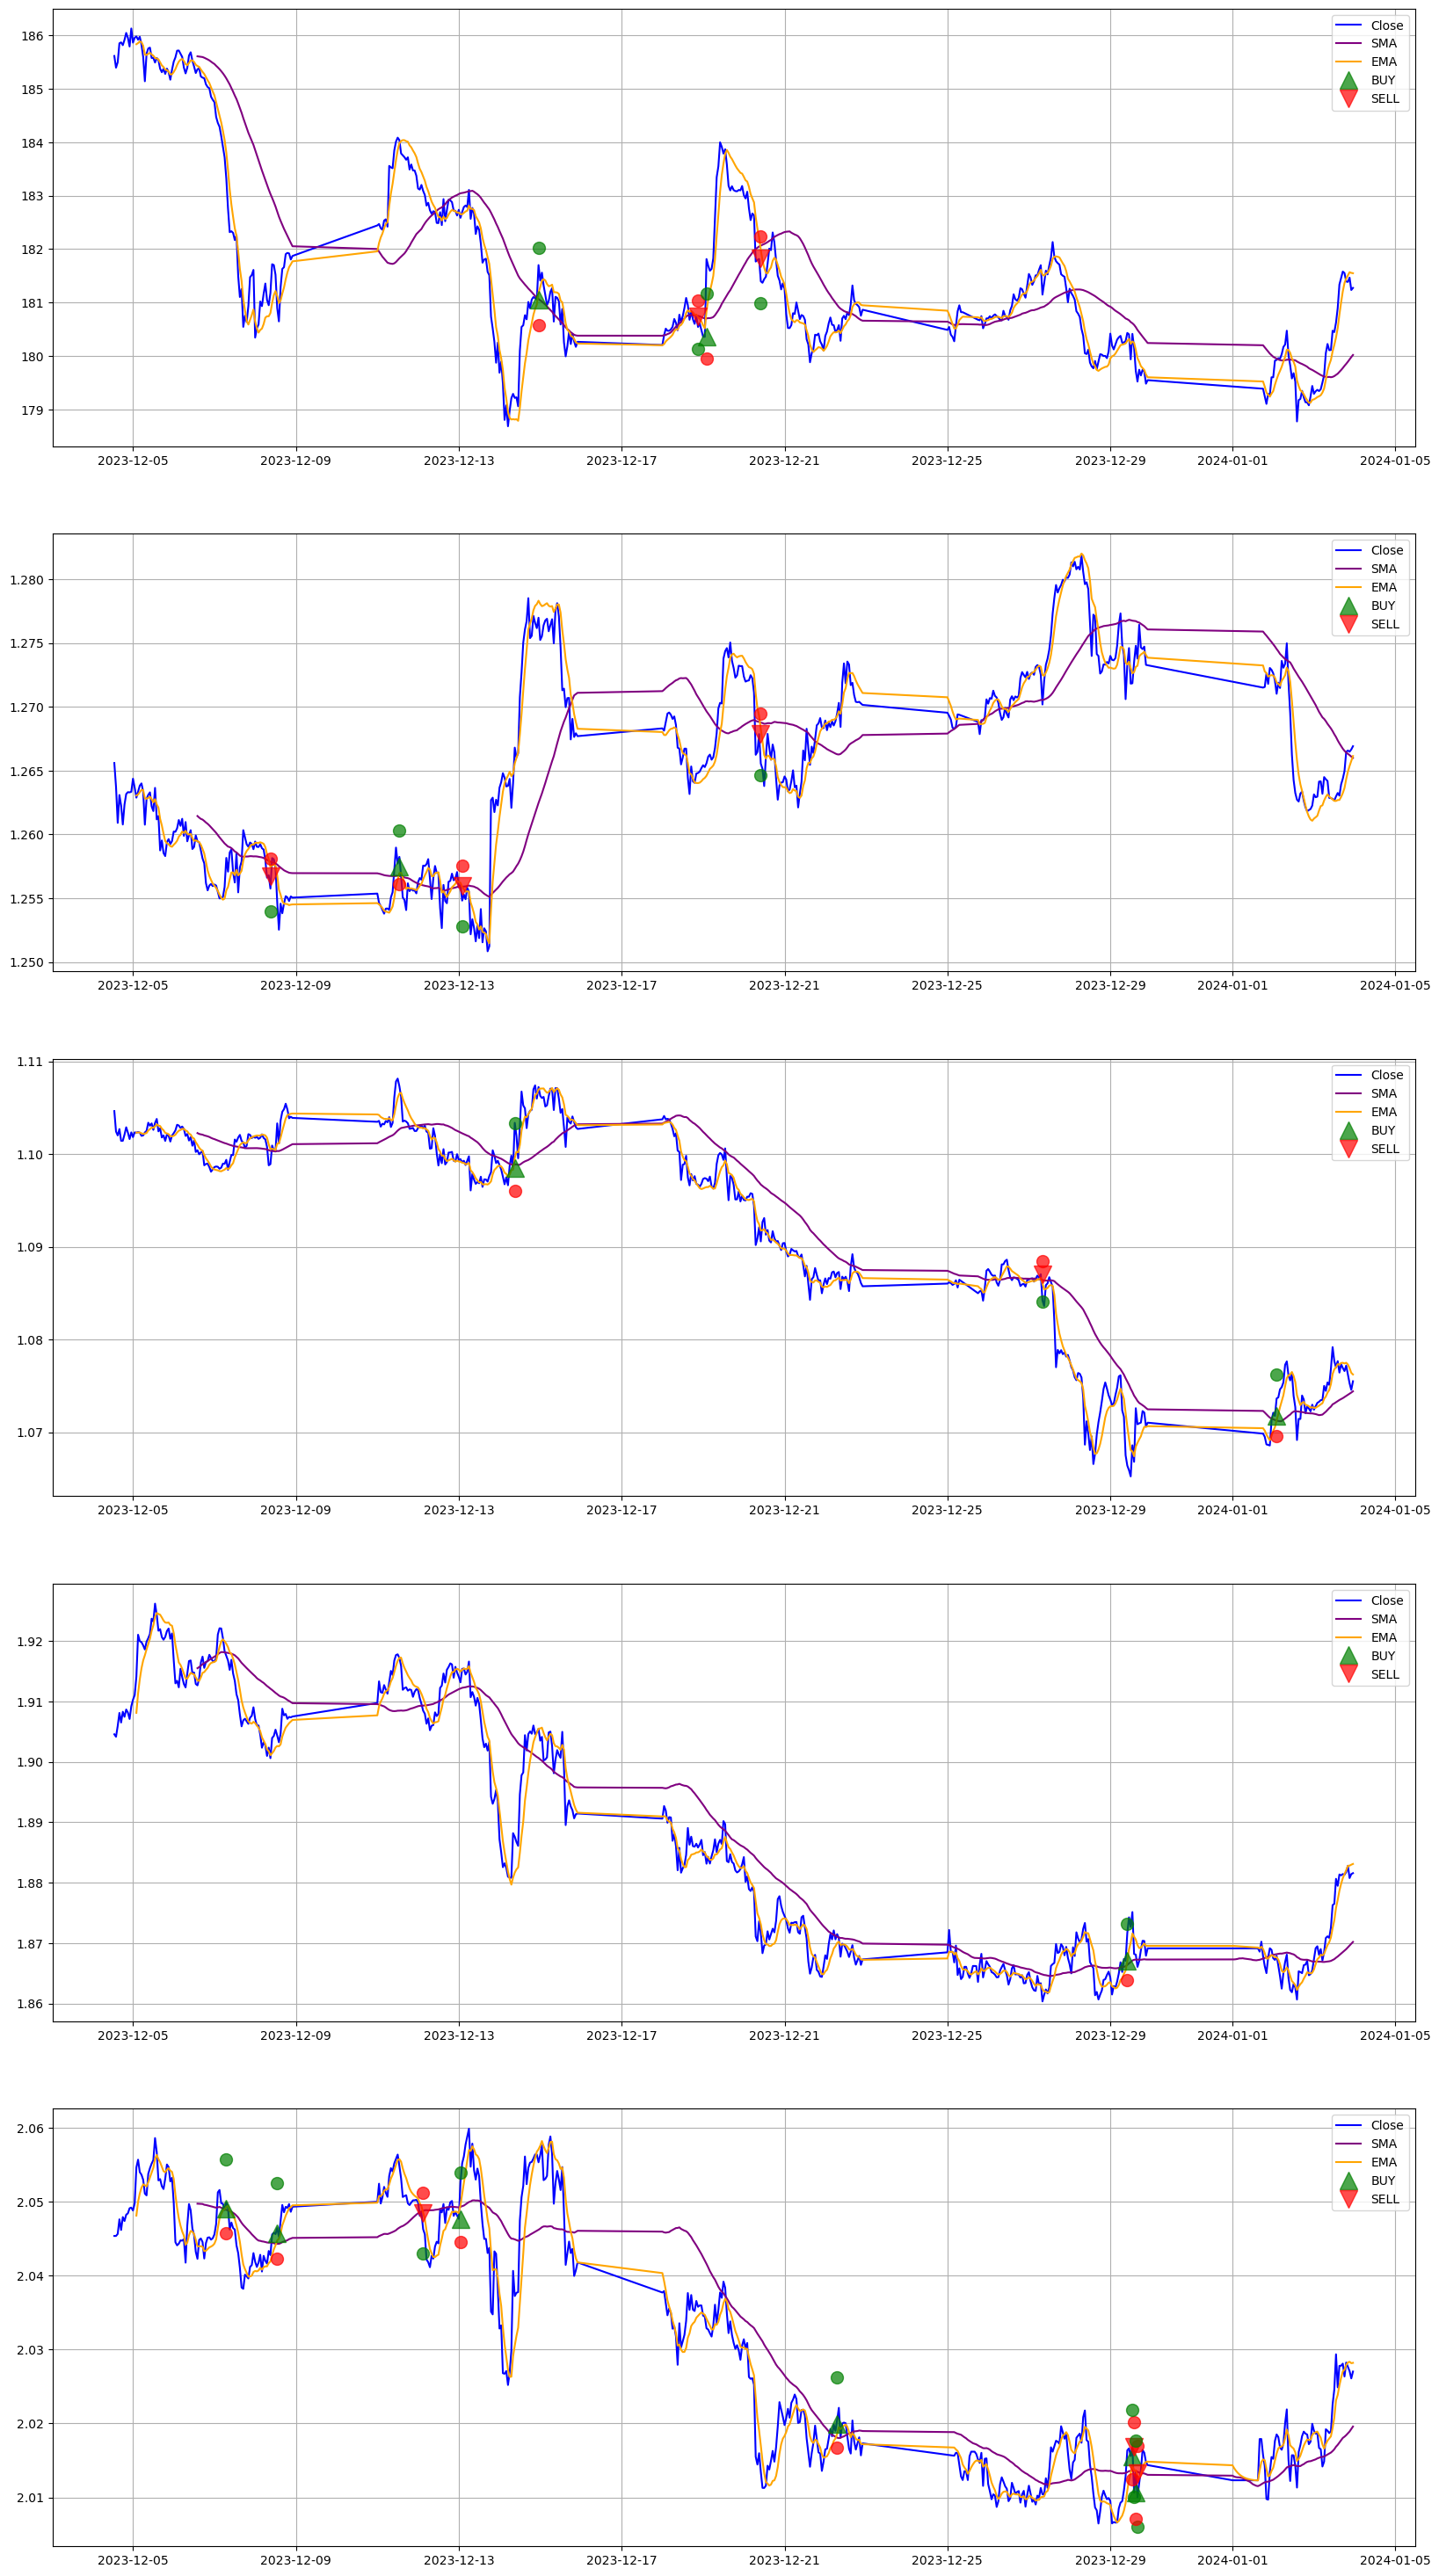

In [25]:
fig, ax = plt.subplots(len(symbols), 1, figsize=(20, len(symbols) * 7.5))
count = 0
for symbol in symbols:

    ax[count].plot(data[symbol]["Close"], color = "b")
    ax[count].plot(data[symbol]["SMA"], color = "purple")
    ax[count].plot(data[symbol]["EMA"], color = "orange")

    ax[count].plot(data[symbol][data[symbol]["position"] == 1.0].index,
              data[symbol]["Open"][data[symbol]["position"] == 1.0], '^', markersize = 15, color = 'g', alpha = 0.7)

    ax[count].plot(data[symbol][data[symbol]["position"] == -1.0].index,
              data[symbol]["Open"][data[symbol]["position"] == -1.0], 'v', markersize = 15, color = 'r', alpha = 0.7)
    
    
    ax[count].plot(data[symbol][data[symbol]["position"] == -1.0].index,
              data[symbol]["Open"][data[symbol]["position"] == -1.0] + (data[symbol]["ATR"][data[symbol]["position"] == -1.0]), 'o', markersize = 10, color = 'r', alpha = 0.7)
    
    ax[count].plot(data[symbol][data[symbol]["position"] == -1.0].index,
              data[symbol]["Open"][data[symbol]["position"] == -1.0] - 2 * (data[symbol]["ATR"][data[symbol]["position"] == -1.0]), 'o', markersize = 10, color = 'g', alpha = 0.7)
    
    ax[count].plot(data[symbol][data[symbol]["position"] == 1.0].index,
              data[symbol]["Open"][data[symbol]["position"] == 1.0] + 2 * (data[symbol]["ATR"][data[symbol]["position"] == 1.0]), 'o', markersize = 10, color = 'g', alpha = 0.7)
    
    ax[count].plot(data[symbol][data[symbol]["position"] == 1.0].index,
              data[symbol]["Open"][data[symbol]["position"] == 1.0] - (data[symbol]["ATR"][data[symbol]["position"] == 1.0]), 'o', markersize = 10, color = 'r', alpha = 0.7)

    ax[count].legend(["Close", "SMA", "EMA", "BUY", "SELL"])
    ax[count].grid()
    
    count += 1
    

plt.show()

In [32]:
from backtesting import Backtest, Strategy

class EMA_cross_SMA_engulfing(Strategy):  
    
    take_prof_ratio = 2
    
    def init(self):     
        pass
    def next(self):
        price = self.data.Close[-1]
        signal = self.data.position[-1]
        sl = self.data.ATR[-1]
        if signal == 1.0:
            if self.position.is_short:
                self.position.close()
            self.buy(sl=(price - sl), tp = (price + (self.take_prof_ratio * sl)))
        elif signal == -1.0:
            if self.position.is_long:
                self.position.close()
            self.sell(sl=(price + sl), tp = (price - (self.take_prof_ratio * sl)))

all_stats = {}
best_prof_ratios = []
for symbol in symbols:
    test_data = data[symbol]
    bt = Backtest(test_data, EMA_cross_SMA_engulfing, cash = 20000)
    #stats, heatmap = bt.optimize(take_prof_ratio = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],
                       #maximize = "Return [%]",
                        #return_heatmap = True)
    #best_prof_ratios.append(heatmap.idxmax()[0])
    stats = bt.run()
    all_stats[symbol] = {"Return" : stats["Return [%]"], "Profit" : float(stats["Equity Final [$]"]) - 20000}
total_ret = 0
total_prof = 0
for symbol in symbols:
    total_ret += all_stats[symbol]["Return"]
    total_prof += all_stats[symbol]["Profit"]

In [33]:
all_stats

{'GBPJPY=X': {'Return': -0.8813799777403255, 'Profit': -176.2759955480651},
 'GBPUSD=X': {'Return': -0.037464646560783875, 'Profit': -7.492929312156775},
 'GBPCHF=X': {'Return': 0.05750443673694463, 'Profit': 11.500887347388925},
 'GBPAUD=X': {'Return': -0.16502328922071682, 'Profit': -33.00465784414337},
 'GBPNZD=X': {'Return': -0.5868841736579998, 'Profit': -117.37683473159996}}

In [34]:
print(total_prof)
print(total_ret)

-322.6495300885763
-1.6132476504428812


In [8]:
from backtesting import Backtest, Strategy

class EMA_cross_SMA_engulfing(Strategy):  
    
    take_prof_ratio = 1.75
    
    def init(self):     
        pass
    def next(self):
        price = self.data.Close[-1]
        signal = self.data.position[-1]
        sl = self.data.ATR[-1]
        if signal == 1.0:
            if self.position.is_short:
                self.position.close()
            self.buy(sl=(price - sl), tp = (price + (self.take_prof_ratio * sl)))
        elif signal == -1.0:
            if self.position.is_long:
                self.position.close()
            self.sell(sl=(price + sl), tp = (price - (self.take_prof_ratio * sl)))


test_data = data
bt = Backtest(test_data, EMA_cross_SMA_engulfing, cash = 20000)
#stats, heatmap = bt.optimize(take_prof_ratio = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],
                   #maximize = "Return [%]",
                    #return_heatmap = True)
#best_prof_ratios.append(heatmap.idxmax()[0])
stats = bt.run()
stats

Start                     2022-01-03 00:00:00
End                       2024-01-04 00:00:00
Duration                    731 days 00:00:00
Exposure Time [%]                    6.486486
Equity Final [$]                 20274.288344
Equity Peak [$]                  20476.019565
Return [%]                           1.371442
Buy & Hold Return [%]               16.816966
Return (Ann.) [%]                    0.661014
Volatility (Ann.) [%]                1.374446
Sharpe Ratio                         0.480931
Sortino Ratio                        0.732942
Calmar Ratio                         0.450326
Max. Drawdown [%]                   -1.467857
Avg. Drawdown [%]                   -0.478475
Max. Drawdown Duration      166 days 04:00:00
Avg. Drawdown Duration       23 days 02:00:00
# Trades                                    9
Win Rate [%]                        33.333333
Best Trade [%]                        2.31071
Worst Trade [%]                     -0.418413
Avg. Trade [%]                    